Reconstruct a single, upsampled high resolution image from a series of low resolution images using Fourier ptychography.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
import os
from PIL import Image
import numpy as np
from scipy.fft import fft2, ifft2
import time
from IPython.display import clear_output


In [2]:
# Functions

# Starting at 7,7, generate coordinates to turn on LEDs in a spiral pattern, moving right up left down right up left down....
# 0,0 is bottom left LED when rotation is 135 degrees
def LED_spiral(n):
    # Input: n; gridsize to generate coordinates for
    # Returns: x_coords, y_coords; arrays for LED coordinates 
    
    # Initialize the arrays to store the x and y coordinates
    x_coords = np.zeros(n**2, dtype=int)
    y_coords = np.zeros(n**2, dtype=int)
    
    # Starting point
    x, y = 7, 7
    x_coords[0], y_coords[0] = x, y
    
    step_size = 1  # How far to move in each direction before changing direction
    index = 1  # Tracks the number of coordinates generated so far
    
    while index < n**2:
        # Move right
        for _ in range(step_size):
            if index >= n**2:
                break
            x += 1
            x_coords[index], y_coords[index] = x, y
            index += 1
        
        # Move up
        for _ in range(step_size):
            if index >= n**2:
                break
            y += 1
            x_coords[index], y_coords[index] = x, y
            index += 1
        
        step_size += 1  # Increase step size after moving right and up
        
        # Move left
        for _ in range(step_size):
            if index >= n**2:
                break
            x -= 1
            x_coords[index], y_coords[index] = x, y
            index += 1
        
        # Move down
        for _ in range(step_size):
            if index >= n**2:
                break
            y -= 1
            x_coords[index], y_coords[index] = x, y
            index += 1
        
        step_size += 1  # Increase step size after moving left and down
    
    return x_coords, y_coords

# Find a suitable size of upscaled object image
def calculate_object_size(img_size, spl, grid_size, LED2SAMPLE, LED_P, NA, WLENGTH):
    r = np.sqrt(2*(grid_size*LED_P*0.5)**2) # Max radius of LED from center
    led_na = r/(np.sqrt(r**2+LED2SAMPLE**2)) # Max NA of LED
    msf = led_na/WLENGTH + NA/WLENGTH # Maximum spacial frequency in x
    
    return np.ceil(2*np.round(2*msf/spl)/img_size)*img_size # obj_size will be a multiple of img_size

# Find the LED positions in Fourier domain
def calculate_fourier_positions(x,y,LED2SAMPLE,WLENGTH,spl):
    kx = np.zeros(len(x))
    ky = np.zeros(len(x))
    for i in range(len(x)):
        sin_thetax = x[i]/(np.sqrt(x[i]**2 + LED2SAMPLE**2))
        kx[i] = sin_thetax/(WLENGTH*spl)
        
        sin_thetay = y[i]/(np.sqrt(y[i]**2 + LED2SAMPLE**2))
        ky[i] = sin_thetay/(WLENGTH*spl)
    
    return kx,ky

# Shifted fourier transform
def FT(x):
    return np.fft.fftshift(fft2(np.fft.ifftshift(x)))

# Shifted inverse fourier transform
def IFT(x):
    return np.fft.fftshift(ifft2(np.fft.ifftshift(x)))

# Reconstruct object and pupil function using Quasi Newton algorithm
def FPM_Quasi_Newton(images, kx, ky, obj, pupil, options):
    # Inputs: 
    # images; low res image array data, in order taken
    # kx,ky; location of LEDs in Fourier domain, in order of images taken
    # obj; initial estimate for object in frequency domain
    # pupil; initial pupil function (mask)
    # options; alpha, beta (regularisation), max_iter, plotting
    
    # Returns: 
    # rec_obj; recovered object
    # rec_pupil; recovered pupil function
    
    # Unpack options
    alpha = options['alpha']
    beta = options['beta']
    max_iter = options['max_iter']
    plotting = options['plotting']
    
    # Other parameters
    img_size = images.shape[0] # Square, same size as pupil function
    img_center = img_size // 2
    num_images = images.shape[2]
    obj_size = obj.shape[0] # Square
    obj_center = obj_size // 2 # Center of object (used for inserting spectra in correct place)
    pupil_binary = np.copy(pupil) # Original pupil function
    
    # For plotting
    if plotting:
        global pupil_radius 
        fig, axes = plt.subplots(1, 4, figsize=(15,15))

    for iter in range(max_iter):
        for i in range(num_images): # For each image in data set   
            x_start = int(obj_center + kx[i] - img_size//2) # For cropping object spectrum (see plots)
            y_start = int(obj_center - ky[i] - img_size//2)  
            
            # Define variables for object and pupil updating 
              
            # The relevant part of object spectrum to update, multiplied by the pupil          
            object_update = np.multiply(obj[y_start:y_start+img_size, x_start:x_start+img_size], pupil) 
             
            # Measured image amplitude
            img = np.sqrt(images[:,:,i])
            
            # Estimated image amplitude from object (complex)
            img_est = IFT(object_update)
            
            # The update image is composed of the magnitude of the measured image, the phase of the estimated image
            # and also the spectrum of the estimated image is subtracted
            update_image = FT(np.multiply(img, np.exp(1j*np.angle(img_est))) - img_est)
            # update_image = FT(img * object_update/ (img_est + 0.0001)) - object_update # FPM_py library?
            # update_image = FT(img) # Testing

            
            print('img,img_est,update_image,object_update')
            print(img[img_center,img_center])
            print(img_est[img_center,img_center])
            print(update_image[img_center,img_center])
            print(object_update[img_center,img_center])
            
            # Object update
            numerator = np.abs(pupil) * np.conj(pupil) * update_image
            denominator = np.max(np.abs(pupil)) * (np.abs(pupil)**2 + alpha)
            object_update = (numerator / denominator)
            obj[y_start:y_start+img_size, x_start:x_start+img_size] += 0.5*object_update # Add to main spectrum
            
            print('object update num and den')
            print(numerator[img_center,img_center])
            print(denominator[img_center,img_center])
               
            # Pupil update
            print('pupil pre')
            print(pupil[img_center,img_center])
            
            numerator = np.abs(object_update) * np.conj(object_update) * update_image * pupil_binary
            denominator = np.max(np.abs(obj)) * (np.abs(object_update)**2 + beta)
            pupil_update = (numerator/denominator)
            pupil += pupil_update
            
            print("pupil post")
            print(pupil[img_center,img_center])
            
            print('pupil update num and den')
            print(numerator[img_center,img_center])
            print(denominator[img_center,img_center])
 
            # Plotting
            if plotting:
                # Clear previous plots
                for ax in axes:
                    ax.cla()  # Clear the current axes
                    
                axes[0].imshow(np.log(np.abs(obj) + 1), cmap='gray') # Show with log scale
                axes[0].set_title(f'Spectrum of object')
                square = patches.Rectangle((x_start, y_start), img_size, img_size, linewidth=0.5, edgecolor='red', facecolor='none')
                axes[0].add_patch(square)
                circle = patches.Circle((obj_center+kx[i],obj_center-ky[i]), radius=pupil_radius,linewidth =0.5, edgecolor='red',facecolor='none')
                axes[0].add_patch(circle)

                axes[1].imshow(np.abs(IFT(obj)), cmap='gray')
                axes[1].set_title('Currently reconstructed object')
                
                axes[2].imshow(np.angle(pupil),cmap='gray')
                axes[2].set_title('Current pupil phase')
                
                axes[3].imshow(np.abs(pupil),cmap='gray')
                axes[3].set_title('Current pupil magnitude')
                
                # Update the figure
                clear_output(wait=True)  # Clear the output before displaying the new figure
                display(fig)  # Display the updated figure
                plt.pause(0.1)  # Pause to allow the figure to update if needed

    return IFT(obj),pupil


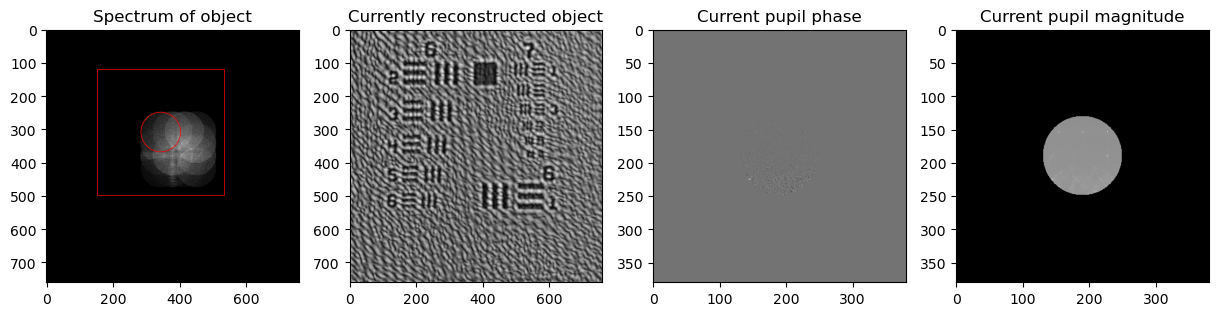

In [4]:
# Main FPM reconstruction. Set up for square, grayscale images.

# Load image data into an array
data_path = 'data/usaf_dark'
grid_size = 4 # 1 -> 16, determines how many images to reconstruct with, it seems corners provide little useful information
img_size = 380 # Size of low res image

num_images = grid_size**2
images = np.zeros((img_size,img_size,num_images)) # Initialise array for storing images
brightfield = np.array(Image.open(os.path.join(data_path,'brightfield.png'))) # Brightfield image for reference

for i in range(num_images): # ~ 2s to load all 256 images into array
    filename = os.path.join(data_path, f'image_{i}.png') # Construct path
    img = np.array(Image.open(filename)) / 256  # Open image and convert to array, with data range 0-1
    images[:,:,i] = img

# Experiment parameters
x_coords, y_coords = LED_spiral(grid_size) # LED coordinates in sequence
LED2SAMPLE = 54 # Distance from LED array to the sample, 54mm (larger distance leads to closer overlapping Fourier circles, optimal 40-60%)
LED_P = 3.3 # LED pitch, mm
N_GLASS = 1.52 # Glass refractive index
NA = 0.1 # Objective numerical apature
PIX_OBJ = 862.5e-9 # Pixel size at object plane, m (3.45um sensor pixel / 4 magnification)
WLENGTH = 550e-9 # Central wavelength of LED light, m

# Derived variables
spl = 1/(img_size*PIX_OBJ) # Sampling size in x
x_abs = [(x - x_coords[0])*LED_P for x in x_coords] # x distances of LEDs from center LED
y_abs = [(y - y_coords[0])*LED_P for y in y_coords] # y distances of LEDs from center LED

# Size of object image (for given parameters upsampling is between 2 and 5 depending on grid_size)
# Can do seperately x and y if image is not square
obj_size = calculate_object_size(img_size, spl, grid_size, LED2SAMPLE, LED_P, NA, WLENGTH)

# Locations of LEDs in Fourier domain
kx,ky = calculate_fourier_positions(x_abs, y_abs, LED2SAMPLE, WLENGTH, spl)

# Initial pupil function (mask)
lim = WLENGTH/(2*NA*PIX_OBJ)
x,y = np.meshgrid(np.linspace(-lim,lim,img_size), np.linspace(-lim,lim,img_size))
theta,r = np.arctan2(y,x), np.sqrt(x**2 + y**2)
mask = r <= 1 # Radius of mask will be (1/lim * img_size/2) = (NA/(WLENGTH*spl))
pupil_radius = NA/(WLENGTH*spl) # For plotting and diagnostics

pupil = np.ones((img_size,img_size),dtype='complex128')
pupil = np.multiply(pupil,mask)

# Initial object estimate (using first image)
img = np.sqrt(images[:,:,0]) # Amplitude of central image
F_img = FT(img) # Fourier transformed image (with shift)
F_img = np.multiply(F_img, pupil) # Apply pupil function
pad_width = int((obj_size - img_size) / 2) # Padding to make correct size
obj = np.pad(F_img,pad_width,'constant',constant_values=0) # Initial object in frequency domain

# Set parameters for Q-N reconstruction algorithm
options = {
    'max_iter': 1, # Number of iterations
    'alpha': 1, # Regularisation parameter, <10
    'beta': 10, # Regularisation parameter, >0
    'plotting': True, # Enable plotting
}

rec_obj, rec_pupil = FPM_Quasi_Newton(images, kx, ky, obj, pupil, options)

Plotting

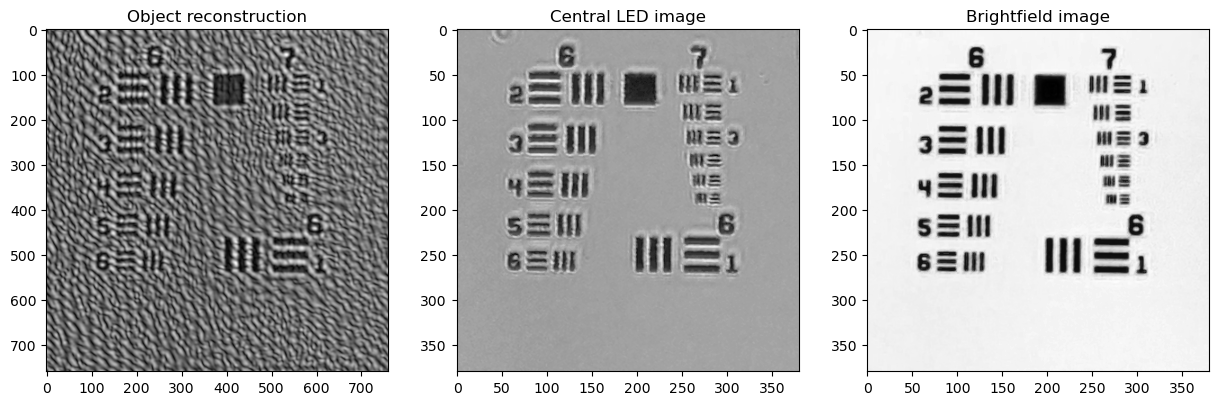

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15,15))

rec_img = np.abs(rec_obj)

axes[0].imshow(rec_img,cmap='gray')
axes[0].set_title('Object reconstruction')
axes[1].imshow(img, cmap='gray')
axes[1].set_title('Central LED image')
axes[2].imshow(brightfield, cmap='gray')
axes[2].set_title('Brightfield image')

rec_img = (rec_img / rec_img.max() * 255).astype(np.uint8)
rec_img = Image.fromarray(rec_img)
rec_img.save('results/testing.png')


Text(0.5, 1.0, 'LED positions in real space and k space')

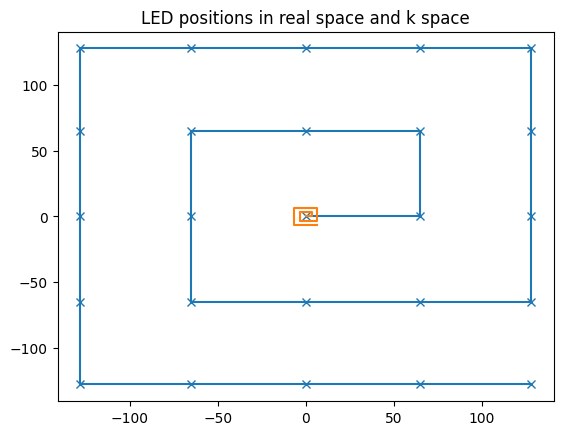

In [68]:
# Show LED sequence and positions in k-space
plt.plot(kx,ky,'-x') 
plt.plot(x_abs,y_abs)
plt.title('LED positions in real space and k space')